### Requirements

In [1]:
from dataset import*
from utility import*
from training import*
from models import*
from torch.optim import lr_scheduler 

# Head pose DL model from https://github.com/thohemp/6drepnet
from sixdrepnet import SixDRepNet

# Import models
from torchvision import models
from vit_pytorch.twins_svt import TwinsSVT # MEMORIA NON SUFFICIENTE RIPROVARLO
#from vit_pytorch.vit import ViT
from vit_pytorch.ats_vit import ViT
from vit_pytorch import SimpleViT
from vit_pytorch.crossformer import CrossFormer # MEMORIA NON SUFFICIENTE RIPROVARLO
from vit_pytorch.cross_vit import CrossViT

In [2]:
root_project = '/home/anto/University/Driving-Visual-Attention/'

In [3]:
print(f"We have {'' if torch.cuda.is_available() else 'not'} access to a GPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device(0))
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))
print(device)

We have  access to a GPU
0
1
NVIDIA GeForce RTX 3060 Laptop GPU
cuda


In [4]:
seed_everything(42)

##### Initialize pre-trained models for feature extraction

In [5]:
# Initialize face detector and facial landmarks predictor
face_detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/home/anto/University/Driving-Visual-Attention/data/data")
headpose_extractor = SixDRepNet()

### Data Loader and Visualization

##### Files where to write the paths and labels

In [6]:
percentage = 5
save_train_file = root_project + 'save/save_train' + str(percentage)
save_val_file = root_project + 'save/save_val' + str(percentage)
save_test_file = root_project + 'save/save_test' + str(percentage)

##### Train Loader

In [7]:
train_dataset_classloader = DataLoaderVisualizer(root_project,save_train_file,percentage, predictor, face_detector, headpose_extractor,'train')

Building path structure

The dataset has already been prepared, ready to use


##### Validtion Loader

In [8]:
val_dataset_classloader = DataLoaderVisualizer(root_project,save_val_file,percentage,predictor, face_detector, headpose_extractor,'val')

Building path structure

The dataset has already been prepared, ready to use


##### Test Loader

In [9]:
#test_dataset_classloader = DataLoaderVisualizer(root_project,save_test_file,percentage,predictor, face_detector, headpose_extractor,'test')

##### Visualization

In [10]:
#train_dataset_classloader.visualize_dataset()

In [11]:
#val_dataset_classloader.visualize_dataset()

In [12]:
#test_dataset_classloader.visualize_dataset()

### Pytorch Dataset 

In [13]:
# Choose size of the eyes
dim = (128,224)
# mean and std of images, calculated in advance
mean = (0.4570, 0.4422, 0.3900)
std = (0.2376, 0.2295, 0.2261)

my_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(dim, antialias=True),
    transforms.Normalize(mean=mean, std=mean, inplace=True)
])

In [14]:
train_dataset = DGAZEDataset('train','save/save_train'+str(percentage),my_transforms)
print(f'Train dataset len is {len(train_dataset)}')

Train dataset len is 1052


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


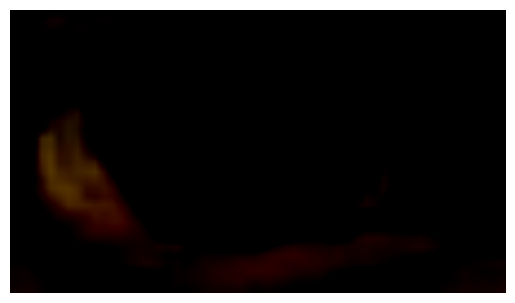

In [15]:
# Print an example of the dataset for correct visualization
img_np = train_dataset[30][0].permute(1, 2, 0).numpy()
plt.imshow(img_np)
plt.axis('off')
plt.show()

In [16]:
val_dataset = DGAZEDataset('val','save/save_val'+str(percentage),my_transforms)
print(f'Val dataset len is {len(val_dataset)}')

Val dataset len is 126


In [17]:
test_dataset = DGAZEDataset('test','save/save_test'+str(percentage),my_transforms)
print(f'Test dataset len is {len(test_dataset)}')

Test dataset len is 126


### Vision Transformer Model

##### Hyerparameters

In [18]:
EPOCHS = 50
BATCH_SIZE = 16
'''
IMAGE_SIZE = 768
HEADS = 8
DROPOUT = 0.1
PATCH_SIZE = 32
DIM = 1024
MLP_DIM= 1024
DEPTH = 4
'''
THRESHOLD = 180
pre_trained = False

In [19]:
'''
model = ViT(
    image_size = IMAGE_SIZE,
    patch_size = PATCH_SIZE,
    num_classes = 2,
    channels= 3,
    pool='mean',
    dim = DIM,
    depth = DEPTH,
    heads = HEADS,
    mlp_dim = MLP_DIM,
    dropout = DROPOUT,
    emb_dropout = 0.1
)

model = SimpleViT(
    image_size = IMAGE_SIZE,
    patch_size = PATCH_SIZE,
    num_classes = 2,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048
)

model = CrossViT(
    image_size = IMAGE_SIZE,
    num_classes = 2,
    depth = 2,               # number of multi-scale encoding blocks
    sm_dim = 192,            # high res dimension
    sm_patch_size = 16,      # high res patch size (should be smaller than lg_patch_size)
    sm_enc_depth = 1,        # high res depth
    sm_enc_heads = 4,        # high res heads
    sm_enc_mlp_dim = 1024,   # high res feedforward dimension
    lg_dim = 384,            # low res dimension
    lg_patch_size = 64,      # low res patch size
    lg_enc_depth = 3,        # low res depth
    lg_enc_heads = 8,        # low res heads
    lg_enc_mlp_dim = 1024,   # low res feedforward dimensions
    cross_attn_depth = 1,    # cross attention rounds
    cross_attn_heads = 4,    # cross attention heads
    dropout = 0.1,
    emb_dropout = 0.1
)

model = ViT(
    image_size = IMAGE_SIZE,
    patch_size = PATCH_SIZE,
    num_classes = 2,
    dim = 1024,
    depth = 6,
    max_tokens_per_depth = (256, 128, 64, 32, 16, 8), # a tuple that denotes the maximum number of tokens that any given layer should have. if the layer has greater than this amount, it will undergo adaptive token sampling
    heads = 8,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

class GazeHeadResNet(nn.Module):
    def __init__(self):
        super(GazeHeadResNet, self).__init__()
        self.resnet34 = models.resnet34(pretrained=True)
        #self.resnet34.avgpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        self.resnet34.fc = nn.Linear(in_features=512, out_features=4, bias=True)

    def forward(self, X):
        h = self.resnet34(X)
        gaze_hat = h[:, :2]
        head_hat = h[:, 2:]
        return gaze_hat
    
model = GazeHeadResNet()
'''
model = GazeCNN()
model.to(device)

GazeCNN(
  (eye_feature_extractor): EyeFeatureExtractor(
    (conv1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (relu): PReLU(num_parameters=1)
    (block): ConvolutionBlock(
      (conv_block): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm_block): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu_block): PReLU(num_parameters=1)
    )
    (pool): MaxPool2d(kernel_size=8, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.25, inplace=False)
    (conv2): Conv2d(32, 8, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_additional): Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=256, out_features=16, bias=True)
    (3): PReLU(num_parameters=1)
  )
  (fc_merge): Sequential(
    (0): Linear(in_features=9232, out_featur

##### Criterion and Optimizer

In [20]:
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.95))
scheduler = lr_scheduler.StepLR(optimizer, step_size=50000, gamma=0.1)

##### Dataloader

In [21]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Training 

In [22]:
if pre_trained:
    ckpt_path = ''
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [23]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: scardino-2020613 (vesuvio-erutta). Use `wandb login --relogin` to force relogin


True

In [24]:
wandb.init(project="GazeViT", name="Modello Nostro lr = 0.01 scheduler")

In [25]:
if pre_trained:
    start_epoch = checkpoint['epoch']
    EPOCHS = start_epoch + EPOCHS
else:
    start_epoch = 0
    EPOCHS = EPOCHS

for epoch in range(start_epoch, EPOCHS):
    # Training
    train_loss = train_epoch(model, train_loader, criterion, scheduler, optimizer, device, epoch)
    wandb.log({"epoch": epoch + 1,"train_loss": train_loss})

    # Validation
    val_loss, val_accuracy = validate(model, val_loader, THRESHOLD, criterion, device, epoch)
    wandb.log({"epoch": epoch + 1,"val_loss": val_loss})
    wandb.log({"epoch": epoch + 1,"val_accuracy": val_accuracy})

    log_image(val_loader, model, device)

# Finish the WandB run
wandb.finish()

Training Epoch 19:  51%|█████     | 33/65 [00:01<00:01, 21.20batch/s, batch loss=231.02]

In [ ]:
save_dict = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}
torch.save(save_dict, root_project + 'save/AdaptiveToken_weights_epochs' + str(EPOCHS)+ '.pth')

### Test